In [1]:
from fastai.text import *

# data

In [8]:
df = pd.read_csv('cookie.txt', sep='\t')

In [ ]:
data_lm = (TextList.from_df(df)
           .random_split_by_pct()
           .label_for_lm()
           .databunch())

In [ ]:
data_lm.save()

In [4]:
data_lm = TextLMDataBunch.load('.')

In [5]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(671, 167)

In [6]:
len(data_lm.train_ds.vocab.itos), len(data_lm.valid_ds.vocab.itos)

(404, 404)

In [155]:
data_lm.show_batch()

idx,text
0,"a path to something better . xxbos xxmaj enjoy the good luck a xxunk brings you . xxbos a chance xxunk xxunk new xxunk to success and xxunk . xxbos xxmaj you learn from your mistakes ... xxmaj you will learn a lot today . xxbos xxmaj if you have something good in your life , do n't let it go ! xxbos xxmaj what ever you 're xxunk is"
1,"xxbos xxmaj xxunk adversity well is the xxunk of your strength . xxbos a dream you have will come true . xxbos xxmaj our deeds determine us , as much as we determine our deeds . xxbos xxmaj never give up . xxmaj you 're not a failure if you do n't give up . xxbos xxmaj there is no xxunk pleasure than seeing your loved ones prosper . xxbos"
2,"one . xxbos xxmaj the love of your life is xxunk into your xxunk this xxunk . xxbos xxmaj love can xxunk a xxunk , if you want it to . xxbos xxmaj adversity is the xxunk of virtue . xxbos xxmaj xxunk xxunk will xxunk you . xxbos a short xxunk will soon xxunk your life with xxunk to share . xxbos xxmaj now is the time to try"
3,"life with xxunk memories . xxbos xxmaj your ability for xxunk will follow with success . xxbos xxmaj its xxunk how much good you can do if you do xxunk xxunk who gets the credit . xxbos xxmaj everyone xxunk . xxmaj you are the best . xxbos xxup life xxup xxunk xxup not xxup in xxup xxunk xxup good xxup xxunk , xxup but xxup in xxup xxunk xxup"
4,"xxmaj you will conquer xxunk to xxunk success . xxbos xxmaj xxunk are often the xxunk , xxunk by xxunk . xxbos xxmaj fortune xxunk the xxunk . xxbos xxmaj an xxunk xxunk xxunk in time can xxunk xxunk . xxbos a journey of a xxunk xxunk xxunk with a single step . xxbos xxmaj sometimes you just need to xxunk on the xxunk . xxbos xxmaj never give up"


In [6]:
np.array([item.shape[0] for item in data_lm.train_ds.items]).mean()

13.76005961251863

# test: no pretrain

In [265]:
learn = language_model_learner(data_lm, bptt=30, emb_sz=250, 
                               nh=300, drop_mult=1)

In [198]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


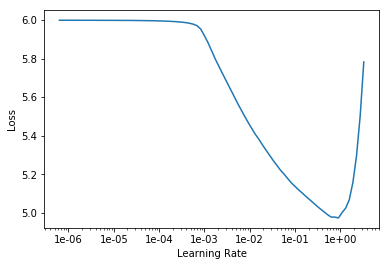

In [199]:
learn.recorder.plot()

In [266]:
learn.fit_one_cycle(5, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,5.916833,5.329801,0.040402
2,5.647674,5.149193,0.044866
3,5.374037,4.307421,0.076786
4,5.112453,4.093303,0.189732
5,4.935962,4.079127,0.189732


In [267]:
learn.unfreeze()

In [268]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


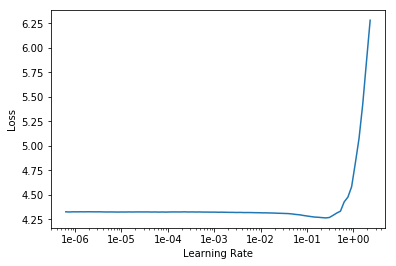

In [269]:
learn.recorder.plot()

In [261]:
len(learn.layer_groups)

4

In [270]:
learn.fit_one_cycle(15, slice(1e-3,1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.312718,4.083159,0.189732
2,4.315265,4.120303,0.189732
3,4.318463,4.093471,0.189732
4,4.323562,4.121953,0.128348
5,4.320823,3.979840,0.237723
6,4.297400,3.845338,0.260045
7,4.260894,3.788445,0.253795
8,4.226642,3.779967,0.260938
9,4.196977,3.744333,0.261161
10,4.169575,3.744239,0.262054


In [271]:
learn.predict('You will be', 30, temperature=0.75)

'You will beyour it the . xxmaj to to at . xxmaj to , if - , not . xxbos xxmaj than what . xxmaj . xxmaj , your . xxbos xxbos'

# pretained

In [7]:
learn_w = language_model_learner(data_lm, bptt=60, drop_mult=1,
                                 pretrained_model=URLs.WT103_1)

In [7]:
learn_w.lr_find(start_lr=1e-9)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


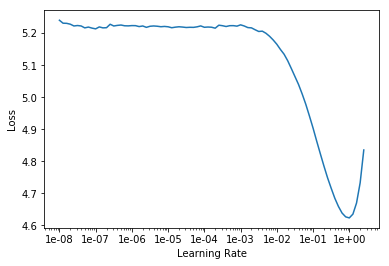

In [8]:
learn_w.recorder.plot()

In [34]:
learn_w.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,5.168423,4.649704,0.178125


In [35]:
learn_w.unfreeze()

In [36]:
learn_w.lr_find(start_lr=1e-9)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


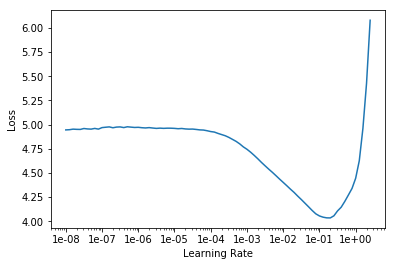

In [37]:
learn_w.recorder.plot()

In [39]:
learn_w.fit_one_cycle(12, slice(1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.932736,4.396491,0.207366
2,4.759596,3.693657,0.315625
3,4.481052,3.036740,0.362500
4,4.214725,2.927209,0.396429
5,3.982860,2.868998,0.411384
6,3.807482,2.849953,0.412723
7,3.669937,2.849688,0.410268
8,3.551310,2.828475,0.413839
9,3.454720,2.811472,0.421205
10,3.372462,2.799727,0.420089


In [42]:
learn_w.predict('you', 30, temperature=0.75)

'youcan have . xxmaj to learn the best of the ways you do . xxbos xxmaj what is what i do not have a situation is the same world .'

In [43]:
learn_w.save('wiki_1')

In [9]:
learn_w.export()

# test performance

In [2]:
learn_w = load_learner('.')

In [32]:
"it's" in learn_w.data.vocab.itos

False

In [43]:
learn_w.data.vocab.textify(learn_w.data.one_item("it's")[0][0])

"it 's"

In [9]:
from collections import Counter

In [10]:
starter_count = Counter([t.split()[0] for t in df.text]).most_common()

In [25]:
starter = [s[0].lower() for s in starter_count[:30]]

In [26]:
starter

['you',
 'the',
 'a',
 'your',
 'if',
 'it',
 'do',
 'be',
 "don't",
 'never',
 'there',
 'love',
 'when',
 "it's",
 'life',
 'all',
 'to',
 'an',
 'in',
 'keep',
 'everything',
 'we',
 'i',
 'today',
 'people',
 'nothing',
 'let',
 'stop',
 'for',
 'good']

In [13]:
def format_output(sentence):
    last_period = sentence.rindex('.')
    if last_period > 0: sentence = sentence[:last_period+1]
    else: sentence += ' .'
    words = sentence.split()
    res = words[0].capitalize()
    for i in range(1, len(words)):
        if words[i] in ['xxmaj', 'xxup']: continue   
        if words[i] == 'xxbos': break
        if words[i] in '.,!?:;"' or words[i][0] == '\'' or words[i][:2] == 'n\'':            
            res += words[i]
            continue
        res += ' '
        if words[i-1] == 'xxmaj': 
            res += words[i].capitalize()
        elif words[i-1] == 'xxup':
            res += words[i].upper()
        else:
            res += words[i]
    return res

In [23]:
format_output(learn_w.predict(random.choice(starter), 30, temperature=0.75))

'Today, in the beginning of the long run.'

In [37]:
format_output(learn_w.predict("don't ", 30, temperature=0.75))

"Don't change a little."